# Import Necessary Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt


# Load and Prepare Data

In [ ]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

# Reshape the data to include channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Function to add noise
def add_noise(images, noise_factor=0.5):
    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise_factor * noise
    return np.clip(noisy_images, 0., 1.)

# Add noise to the images
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)





4422102/4422102 [==============================] - 0s 0us/step


# Build the Autoencoder Model

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7385

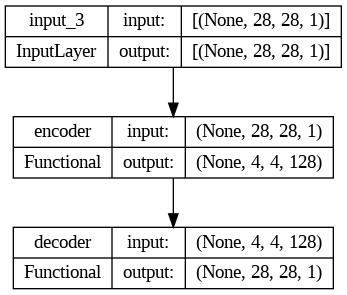

In [ ]:
# Build the Encoder

def build_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    encoder = models.Model(inputs, encoded, name="encoder")
    return encoder

encoder = build_encoder((28, 28, 1))
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)



# Build the Decoder

def build_decoder():
    encoded_input = tf.keras.Input(shape=(4, 4, 128))
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = layers.Cropping2D(((2, 2), (2, 2)))(x)  # Cropping to ensure the final shape matches (28, 28, 1)

    decoder = models.Model(encoded_input, decoded, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)



# Build the Autoencoder

def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(shape=(28, 28, 1))
    encoded = encoder(inputs)
    decoded = decoder(encoded)

    autoencoder = models.Model(inputs, decoded, name="autoencoder")
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)





# Train the Autoencoder

In [ ]:
# Train the Autoencoder

# Train the Autoencoder
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)




Epoch 1/50
235/235 [==============================] - 14s 23ms/step - loss: 0.3513 - val_loss: 0.3125
Epoch 2/50
235/235 [==============================] - 4s 17ms/step - loss: 0.3052 - val_loss: 0.3050
Epoch 3/50
235/235 [==============================] - 4s 18ms/step - loss: 0.2989 - val_loss: 0.3008
Epoch 4/50
235/235 [==============================] - 4s 18ms/step - loss: 0.2953 - val_loss: 0.2968
Epoch 5/50
235/235 [==============================] - 4s 18ms/step - loss: 0.2929 - val_loss: 0.2939
Epoch 6/50
235/235 [==============================] - 4s 18ms/step - loss: 0.2912 - val_loss: 0.2946
Epoch 7/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2899 - val_loss: 0.2918
Epoch 8/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2888 - val_loss: 0.2911
Epoch 9/50
235/235 [==============================] - 4s 18ms/step - loss: 0.2878 - val_loss: 0.2907
Epoch 10/50
235/235 [==============================] - 4s 18ms/step - loss: 0.2871 - val_l

# Visualise the training and validation loss

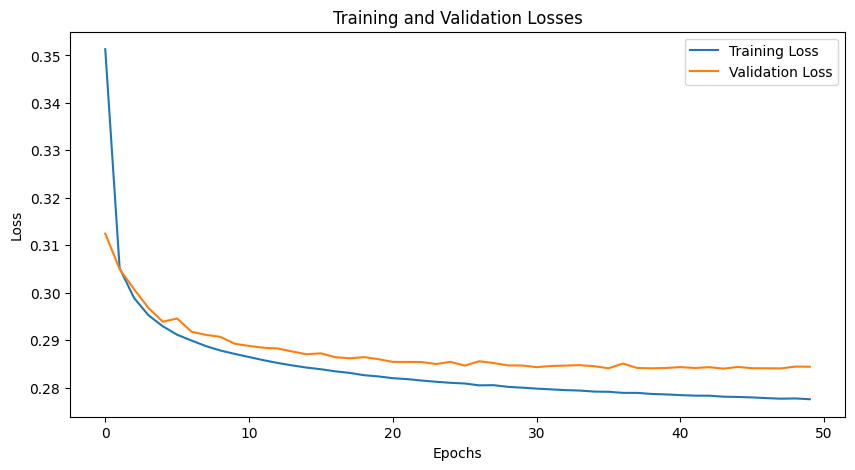

In [ ]:
# Plotting the training and validation losses


# Plot the Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluate the Results

313/313 [==============================] - 1s 2ms/step


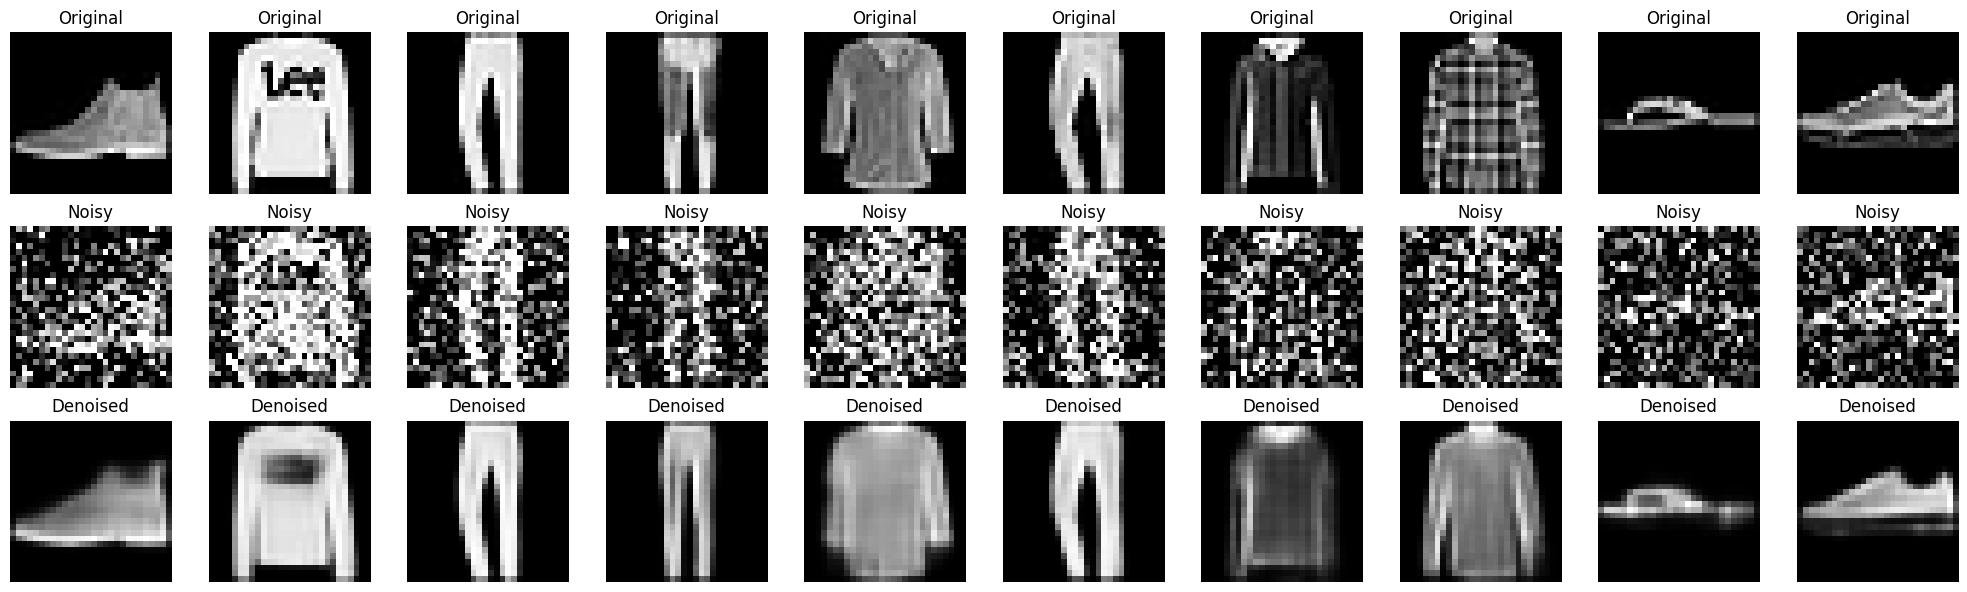

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(original, noisy, denoised, n=10):
    """
    Visualizes the original, noisy, and denoised images in a comparative layout.

    Parameters:
        original (numpy array): Array of original images.
        noisy (numpy array): Array of noisy images.
        denoised (numpy array): Array of denoised images.
        n (int): Number of images to display.
    """
    plt.figure(figsize=(20, 6))

    # Display original images
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Display noisy images
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

    # Display denoised images
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate denoised images using the autoencoder
decoded_imgs = autoencoder.predict(x_test_noisy)

# Use the function to visualize the results
visualize_results(x_test, x_test_noisy, decoded_imgs)

